In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from data.task_multi import multi
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import utils

In [457]:
'''
class encoder(nn.Module):
    def __init__(self, point_num = 5, hidden_dim=10):
        super(encoder, self).__init__()
        self.l1 = nn.Linear(2 * point_num, 50)
        self.mean = nn.Linear(50, hidden_dim)
        self.var = nn.Linear(50, hidden_dim)
    def forward(self, x, return_embed = False):
        x1 = F.relu(self.l1(x))
        mean = self.mean(x1)
        log_std = self.var(x1)
        return mean, log_std
    
class decoder(nn.Module):
    def __init__(self, hidden_dim=10):
        super(decoder, self).__init__()
        self.l1 = nn.Linear(hidden_dim, 50)
        self.l2 = nn.Linear(50,2)
    def forward(self, x):
        x1 = F.relu(self.l1(x))
        x2 = self.l2(x1)
        return x2
'''
class encoder(nn.Module):   
    def __init__(self, hidden_size = 40, batch_size = 32, latent_size = 10):
        super(encoder, self).__init__()
        self.batch_size = batch_size
        self.hidden_size = hidden_size
        self.latent_size = latent_size
        self.l1 = nn.Linear(2, 2)
        self.mean = nn.Linear(self.hidden_size, self.latent_size)
        self.log_std = nn.Linear(self.hidden_size, self.latent_size)
        self.gru = nn.GRU(2, self.hidden_size, batch_first=True)
                           
    def forward(self, input): # input = batch * 10 * 2
        x = self.l1(input)# batch * 10 * 2
        hidden = self.hidden()
        output, hidden = self.gru(x, hidden)
        out = x
        mean = self.mean(hidden)[0]# 1 * batch * latent
        log_std = self.log_std(hidden)[0]
        return mean, log_std, out
    
    def hidden(self):
        return torch.zeros((1, self.batch_size, self.hidden_size))
    
class decoder(nn.Module):   
    def __init__(self, reverse = True, hidden_size = 40, batch_size = 32):
        super(decoder, self).__init__()
        self.reverse = reverse
        self.batch_size = batch_size
        self.hidden_size = hidden_size
        self.l1 = nn.Linear(self.hidden_size,2)
        self.gru = nn.GRU(2, self.hidden_size, batch_first=True)
                           
    def forward(self, hidden, step):# input = batch * 10 * 2
        out = []
        output = torch.zeros((self.batch_size, 1, 2))
        output, hidden = self.gru(output, hidden)#b*1*hidden_size
        output = self.l1(output)
        out.append(output)
        for step in range(step-1):
            output, hidden = self.gru(output, hidden)
            output = self.l1(output)
            out.append(output)
        if self.reverse:
            out = out[::-1]
        
        out = torch.cat(out,dim=1)
        return out
    
    def hidden(self):
        return torch.zeros((1, self.batch_size, self.hidden_size))
    
class classifer(nn.Module):
    def __init__(self, input_size = 10, num=4):
        super(classifer, self).__init__()
        self.num = num
        self.l1 = nn.Linear(input_size, 50)
        self.l2 = nn.Linear(50, num)
    def forward(self, x):
        x1 = F.relu(self.l1(x))
        x2 = F.softmax(self.l2(x1), dim = -1)
        return x2
    
class sample(nn.Module):
    def __init__(self):
        super(sample, self).__init__()
    def forward(self, mean, log_std):
        epsilon = torch.randn((mean.shape[0], mean.shape[1]))
        return mean + torch.exp(log_std) * epsilon

class vae(nn.Module):
    def __init__(self, batch_size=32, hidden_size=2, latent_size=2, class_num = 4):
        super(vae, self).__init__()
        self.latent_size = latent_size
        self.class_num = class_num
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.encoder = encoder(batch_size=batch_size, hidden_size=hidden_size, latent_size=latent_size)
        self.decoder = decoder(hidden_size = latent_size, batch_size = batch_size)
        self.classifer = classifer(input_size = latent_size, num=class_num)
        self.sample = sample()
        self.mean = nn.Parameter(torch.zeros([class_num, latent_size]))
        
    def forward(self, x, return_kl=False):# batch * point * 2
        mean, log_std, train_targets = self.encoder(x)# batch * ?
        z = self.sample(mean, log_std)# batch * latent_size
        hidden_state = torch.unsqueeze(z, dim = 0)# 1 * b * latent
        recon = self.decoder(hidden_state, step = x.shape[1])#b * point * 2(10)
        cate = self.classifer(z)# batch * class
        if return_kl:
            kl_loss, cat_loss = self.kl_loss(z, recon, cate, log_std)
            return z,recon,cate, train_targets, kl_loss, cat_loss
        else:
            return z,recon,cate, train_targets
    
    def kl_loss(self, z, recon, cate, z_log_std):
        expand_z = z.unsqueeze(dim = 1).expand([-1, self.class_num, -1])#batch * class * latent
        expand_mean = self.mean.unsqueeze(dim = 0).expand([self.batch_size, -1, -1])
        distance = expand_z - expand_mean
        kl_loss = torch.sum(- 2 * z_log_std.unsqueeze(dim=1) + torch.exp(2 * z_log_std).unsqueeze(dim=1)\
                            + distance ** 2 - 1, dim = -1)#batch * class
        kl_loss = torch.mean(torch.sum(kl_loss * cate, dim=1))
        cat_loss = torch.mean(torch.sum(cate * torch.log(cate * self.class_num + 1e-10), dim = 1))
        return kl_loss, cat_loss
    
    def mse_loss(self, target, recon):
        return torch.nn.MSELoss()(target, recon)#torch.sum(torch.mean((target-recon) ** 2,dim=0))

In [458]:
batch = 64
task_family_train = multi()
task_family_test = multi()
model = vae(batch_size = batch)
model_optim = torch.optim.Adam(model.parameters(),lr=1e-4)
#center_optim = torch.optim.Adam([model.mean],lr=1e-4)

In [459]:
model.train()
loss = []
for b in range(3000):
    train_inputs = []
    # sample tasks
    target_function = task_family_train.sample_tasks(batch)
    for t in range(batch):        
        x = task_family_train.sample_inputs(10)
        y = target_function[t](x)
        data = torch.cat([x,y],dim=1)# 10 * 2
        train_inputs.append(data)
    train_inputs = torch.stack(train_inputs,dim=0)# batch * 10 * 2
    z,recon,cate, train_targets, kl_loss, cat_loss = model(train_inputs, True)
    mse_loss = model.mse_loss(train_targets, recon)
    
    # get targets
    #train_targets = train_inputs
    task_loss =  mse_loss +  0.5 * kl_loss +  0.5 * cat_loss
    task_loss.backward()
    model_optim.step()
    #center_optim.step()
    loss.append(task_loss)

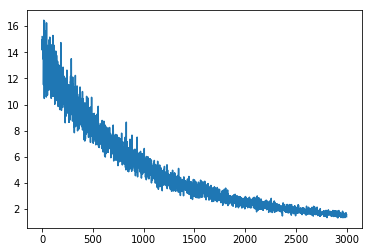

In [460]:
plt.plot(loss)
plt.show()

In [461]:
mse_loss

tensor(0.7515, grad_fn=<MeanBackward1>)

In [462]:
kl_loss

tensor(1.2630, grad_fn=<MeanBackward1>)

In [463]:
model.mean

Parameter containing:
tensor([[ 0.3151, -0.3113],
        [ 0.3639, -0.3545],
        [ 0.3570, -0.3207],
        [-0.4114, -0.3469]], requires_grad=True)

In [464]:
#test
loss = 0
ty = []
hidden = []
model.eval()
for b in range(30):
    train_inputs = []
    # sample tasks
    target_function,type = task_family_test.sample_tasks(batch,True)
    for t in range(batch):        
        x = task_family_test.sample_inputs(10)
        y = target_function[t](x)
        data = torch.cat([x,y],dim=1)# 10 * 2
        train_inputs.append(data)
    train_inputs = torch.stack(train_inputs,dim=0)# batch * 10 * 2
    z,recon,cate, train_targets = model(train_inputs)
    ty.append(np.array(type))
    hidden.append(z.detach().numpy())
ty = np.concatenate(ty,axis=0)
hidden = np.concatenate(hidden,axis=0)

In [465]:
hidden.shape

(1920, 2)

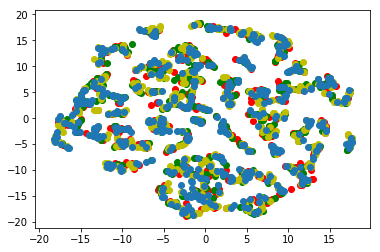

In [466]:
tsne = TSNE(n_components=2)
y = tsne.fit_transform(hidden)
import matplotlib.pyplot as plt
plt.scatter(y[ty==0][:,0],y[ty==0][:,1],c='r')
plt.scatter(y[ty==1][:,0],y[ty==1][:,1],c='g')
plt.scatter(y[ty==2][:,0],y[ty==2][:,1],c='y')
plt.scatter(y[ty==3][:,0],y[ty==3][:,1])
plt.show()

In [453]:
torch.argmax(cate,dim = 1)

tensor([1, 2, 2, 0, 2, 3, 3, 2, 0, 2, 0, 0, 2, 0, 2, 2, 3, 2, 2, 0, 2, 3, 2, 3,
        3, 2, 2, 2, 3, 0, 1, 2, 2, 0, 3, 2, 1, 2, 3, 3, 2, 0, 2, 0, 2, 2, 3, 2,
        2, 0, 0, 2, 2, 3, 2, 0, 0, 0, 0, 3, 2, 0, 2, 0])

In [454]:
type

[1,
 0,
 3,
 1,
 1,
 0,
 1,
 1,
 0,
 2,
 1,
 3,
 1,
 3,
 2,
 0,
 2,
 3,
 0,
 0,
 1,
 3,
 3,
 3,
 1,
 1,
 3,
 2,
 1,
 3,
 0,
 1,
 3,
 3,
 0,
 1,
 3,
 1,
 1,
 3,
 2,
 1,
 3,
 3,
 0,
 3,
 3,
 2,
 2,
 2,
 1,
 1,
 0,
 3,
 2,
 1,
 3,
 0,
 2,
 3,
 1,
 1,
 0,
 0]

In [455]:
tsne = TSNE(n_components=2)
y = tsne.fit_transform(model.mean.detach().numpy())

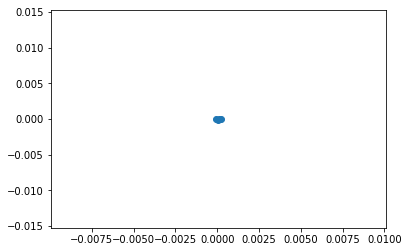

In [456]:
plt.scatter(y[:,0],y[:,1])
plt.show()

In [352]:
for i in range(20):
    c[i,:] = b[i] @ a[i]
torch.sum(torch.mean(c,dim=0))

tensor(1.7581)

In [354]:
z = torch.sum(a,dim=-1)
y = b.squeeze(dim=1)
torch.mean(torch.sum(z*y,dim=-1))

tensor(1.7581)